In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import seaborn as sns

In [4]:
src = "../data/processed"
dst = "../plots"

In [5]:
fname = "study_data.csv.gzip"
data = pd.read_csv(
    Path(src, fname),
    dtype={"id":str, "author_id":str},
    parse_dates=["created_at", "ELECTIONDATE"],
    compression="gzip"
)

fname = "pilot_data1.csv.gzip"
pilot1 = pd.read_csv(
    Path(src, fname),
    dtype={"id":str, "author_id":str},
    parse_dates=["created_at", "ELECTIONDATE"],
    compression="gzip"
)

fname = "pilot_data2.csv.gzip"
pilot2 = pd.read_csv(
    Path(src, fname),
    dtype={"id":str, "author_id":str},
    parse_dates=["created_at", "ELECTIONDATE"],
    compression="gzip"
)

In [6]:
candidates = data[["handle", "ELECTIONDATE", "id"]]\
    .groupby(["handle", "ELECTIONDATE"])\
    .count()\
    .drop(columns=["id"])\
    .reset_index()
candidates = candidates.drop_duplicates(subset=["handle", "ELECTIONDATE"])
candidates.head(3)

,handle,ELECTIONDATE
0,1haywood,2022-05-17
1,aarikarhodes,2022-06-07
2,aazamishervin,2022-06-07


In [7]:
pilot1["time period"] = "pilot data before"
pilot2["time period"] = "pilot data after"
data["time period"] = "study data"
plot_data = pd.concat([pilot1, pilot2, data])
plot_data = plot_data.reset_index()

In [8]:
def plot_election_dates(ax, candidates, start_date, end_date):
    bins = pd.date_range(start=start_date, end=end_date,freq='ME')
    n, b, patches = ax.hist(
        candidates["ELECTIONDATE"], 
        bins=bins, 
        rwidth=0.8, 
        color=(0.7, 0.7, 0.7),
        align="left"
    )
    ax.set_xlabel('')
    ax.set_ylabel('election count')
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xlim(start_date, end_date)
    ax.set_ylim(0, 500)
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%B %Y'))
    ax.set_xticklabels(["Jan 2022", "March 2022", "May 2022", "July 2022", 
                        "Sept 2022", "Nov 2022", "Jan 2023", "March 2023", "May 2023"])
    ax.tick_params(axis='x', rotation=45, which='major')

    return patches

In [9]:
def plot_tweet_density(ax, plot_data, start_date, end_date):
    kde_plot = sns.kdeplot(
        data=plot_data,
        ax=ax2,
        x="created_at",
        hue="time period",
        palette="Set2",
        linewidth=0,
        fill=True,
        alpha=.5,
        hue_order=["pilot data before", "study data", "pilot data after"],
    )
    ax.set_ylabel("tweet density")
    ax.spines[['left', 'top']].set_visible(False)
    ax.set_xlim(start_date, end_date)
    ax.set_ylim(0, 0.004)

    return kde_plot

/tmp/ipykernel_65996/2655498587.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Jan 2022", "March 2022", "May 2022", "July 2022",


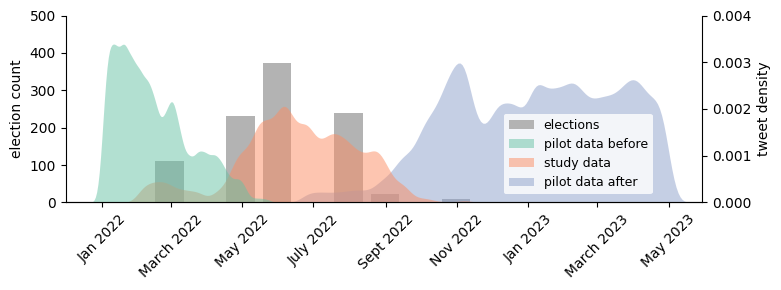

In [10]:
fig, ax1 = plt.subplots(figsize=(8, 3))
ax2 = ax1.twinx()

start_date = pd.to_datetime('2021-12-01')
end_date = pd.to_datetime('2023-05-30')

kde_plot = plot_tweet_density(ax2, plot_data, start_date, end_date)
patches = plot_election_dates(ax1, candidates, start_date, end_date)

# legend
kde_lines = kde_plot.lines
handles1 = [patches[0]]
labels1 = ["elections"]
handles2 = kde_plot.legend_.legend_handles
labels2 = [t.get_text() for t in kde_plot.legend_.texts]
all_handles = handles1 + handles2
all_labels = labels1 + labels2

leg = fig.legend(
    all_handles, 
    all_labels, 
    loc=7, 
    bbox_to_anchor=(0.83, 0.47, 0, 0),
    facecolor='white', 
    edgecolor='none',
    fontsize=9
)
ax2.legend_.remove() # remove legend created by seaborn
fig.tight_layout()

fname = "data_distribution"
dst = "../plots"
plt.savefig(Path(dst, fname + ".pdf"))
plt.savefig(Path(dst, fname + ".svg"))